<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [4]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import patsy
from matplotlib.ticker import FuncFormatter

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn
sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [5]:
# Load the data
house = pd.read_csv('./housing.csv', index_col = "Id")

In [6]:
# A:
house.columns

Index([u'MSSubClass', u'MSZoning', u'LotFrontage', u'LotArea', u'Street',
       u'Alley', u'LotShape', u'LandContour', u'Utilities', u'LotConfig',
       u'LandSlope', u'Neighborhood', u'Condition1', u'Condition2',
       u'BldgType', u'HouseStyle', u'OverallQual', u'OverallCond',
       u'YearBuilt', u'YearRemodAdd', u'RoofStyle', u'RoofMatl',
       u'Exterior1st', u'Exterior2nd', u'MasVnrType', u'MasVnrArea',
       u'ExterQual', u'ExterCond', u'Foundation', u'BsmtQual', u'BsmtCond',
       u'BsmtExposure', u'BsmtFinType1', u'BsmtFinSF1', u'BsmtFinType2',
       u'BsmtFinSF2', u'BsmtUnfSF', u'TotalBsmtSF', u'Heating', u'HeatingQC',
       u'CentralAir', u'Electrical', u'1stFlrSF', u'2ndFlrSF', u'LowQualFinSF',
       u'GrLivArea', u'BsmtFullBath', u'BsmtHalfBath', u'FullBath',
       u'HalfBath', u'BedroomAbvGr', u'KitchenAbvGr', u'KitchenQual',
       u'TotRmsAbvGrd', u'Functional', u'Fireplaces', u'FireplaceQu',
       u'GarageType', u'GarageYrBlt', u'GarageFinish', u'GarageCars'

In [7]:
#display columns and rows
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [8]:
house

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900


In [9]:
house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-

In [10]:
#get dataframe with residential tags
residential = ["RH", "RL", "RP", "RM", "FV"]
house = house[house["MSZoning"].isin(residential)]
house.shape

(1450, 80)

In [11]:
#display null count for columns
missing = house.isnull().sum()
missing_col = missing[missing != 0]
missing[missing != 0].sort_values(ascending = False)

PoolQC          1443
MiscFeature     1398
Alley           1361
Fence           1172
FireplaceQu      681
LotFrontage      259
GarageYrBlt       79
GarageType        79
GarageFinish      79
GarageQual        79
GarageCond        79
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

In [12]:
#categorise all categorical columns
missing_cat = ["PoolQC","Alley", "Fence", "MiscFeature", "FireplaceQu", "GarageYrBlt", "GarageType", "GarageFinish","GarageQual", "GarageCond", "BsmtFinType2", "BsmtExposure", "BsmtFinType1", "BsmtCond", "BsmtQual","MasVnrType" ]

#fill null values of categorical columns with None 
for cat in missing_cat:
    house[cat].fillna("None", inplace = True)

In [13]:
#categorise all numerical columns
missing_num = ["MasVnrArea"]

#fill null values of categorical columns with None
for num in missing_num:
    house[num].fillna(0, inplace = True)

In [14]:
#fill null with median of the neighborhood 
house["LotFrontage"].fillna(house.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median())), inplace = True)

In [15]:
#fill null with mode of electrical
house["Electrical"].fillna(str(house["Electrical"].mode()), inplace = True)

In [16]:
#check for any missing null values
missing = house.isnull().sum()
missing[missing != 0].sort_values(ascending=False)

Series([], dtype: int64)

In [17]:
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score

#function to plot correlation graph
def corr_heatmap(data, method = "pearson"):
    #set the default matplotlib figure size:
    mean_corr = data.corr(method = method)
    
    #generate mask for the upper triangle (taken from seaborn example gallery)
    mask = np.zeros_like( mean_corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    #plot heatmap with seaborn.
    #assign the matplotlib axis the function returns. This resizes the labels.
    fig, ax = plt.subplots(figsize=(16,17))
    ax = sns.heatmap(mean_corr, ax=ax,  square = True, mask=mask, linecolor='white', annot = True, cmap='PiYG', vmin=-1, vmax=1, fmt = '.2f')

    #resize the labels.
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=90)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

    plt.show()
    
def currency(x, pos):
    return '${:1.0f}K'.format(x*1e-3)

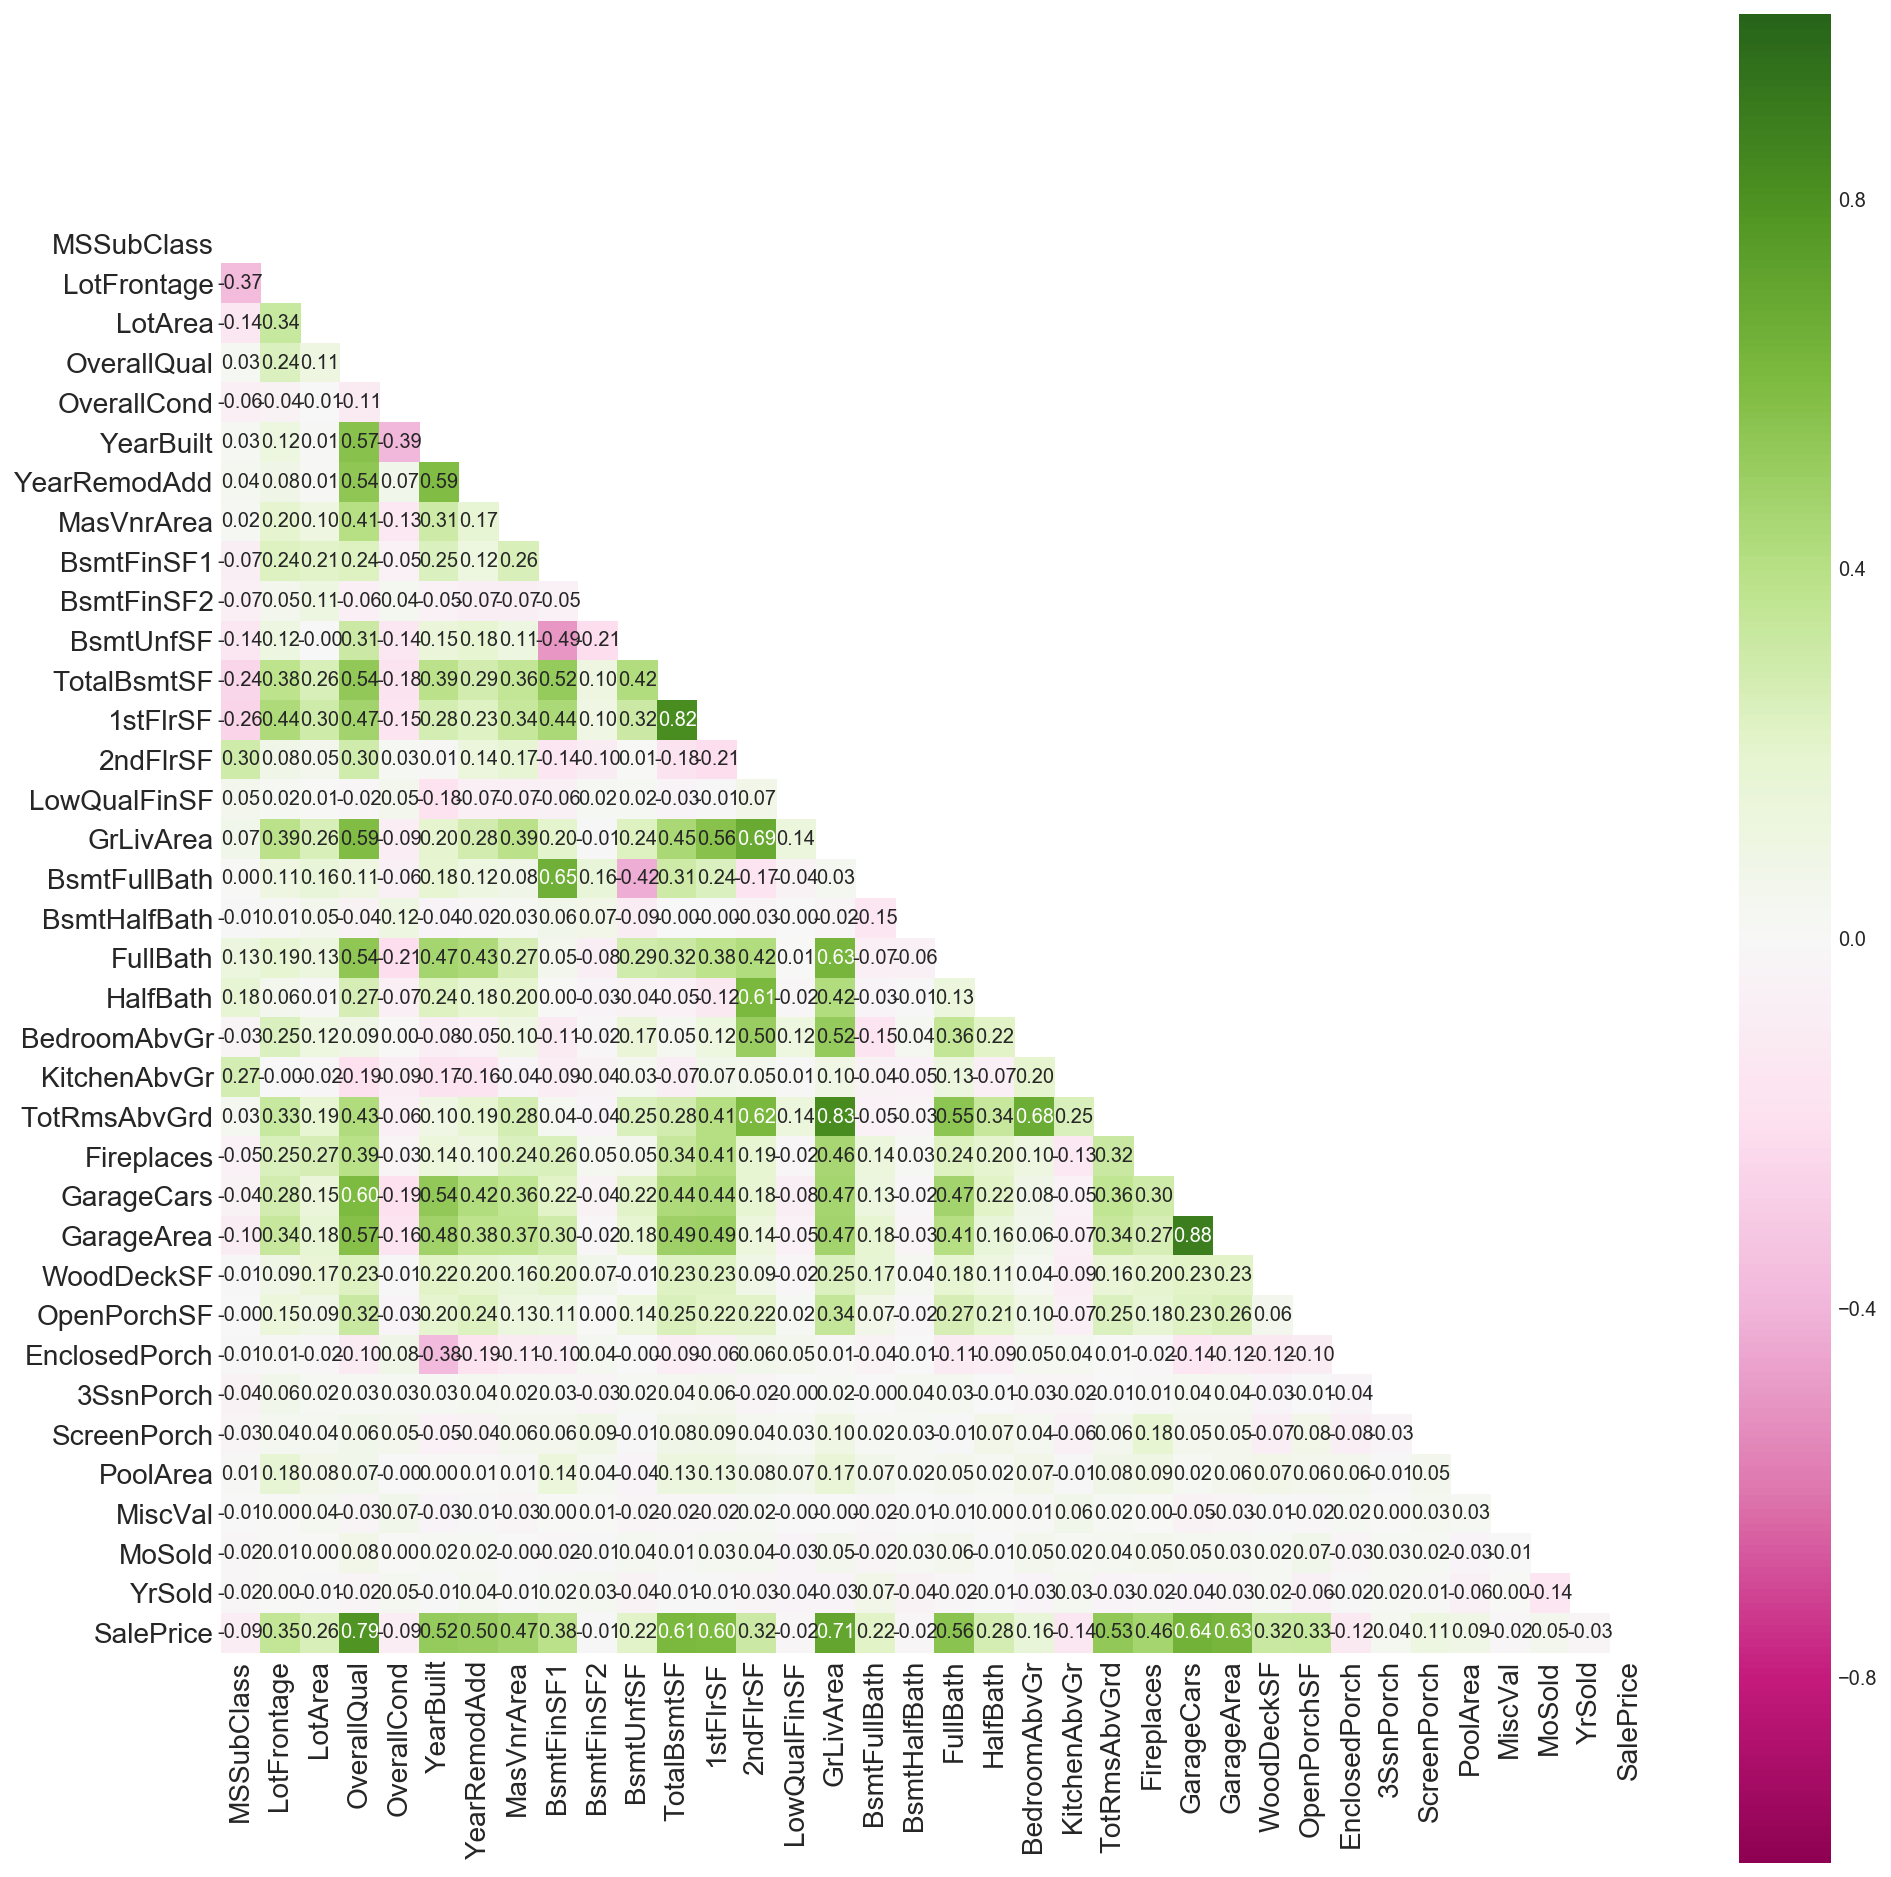

In [18]:
corr_heatmap(house)

In [3]:
#YearBuilt and YearRemodAdd are changed into Age where age is defined to be 2010 minus their respective years.
#Surface Area is created to remove the strong correlations between surface area of other aspects as visualised in the correlation heatmap.

In [18]:
house

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000
6,50,RL,85.0,14115,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,None,Attchd,1993,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000
7,20,RL,75.0,10084,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,None,None,None,0,8,2007,WD,Normal,307000
8,60,RL,80.0,10382,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,None,None,Shed,350,11,2009,WD,Normal,200000
9,50,RM,51.0,6120,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,None,None,None,0,4,2008,WD,Abnorml,129900


In [19]:
#create column to calc age of house
house["Age"] = house["YearBuilt"].map(lambda x: 2010 - x)

#create column to calc age of house after remodeling
house["Remod_Age"] = house["YearRemodAdd"].map(lambda x: 2010 - x)

#create column to add sq of house
house["Total_SF"] = house["TotalBsmtSF"] + house["1stFlrSF"] + house["2ndFlrSF"]

In [39]:
house
house.select_dtypes(exclude=[object]).columns

Index([u'MSSubClass', u'LotFrontage', u'LotArea', u'OverallQual',
       u'OverallCond', u'YearBuilt', u'YearRemodAdd', u'MasVnrArea',
       u'BsmtFinSF1', u'BsmtFinSF2', u'BsmtUnfSF', u'TotalBsmtSF', u'1stFlrSF',
       u'2ndFlrSF', u'LowQualFinSF', u'GrLivArea', u'BsmtFullBath',
       u'BsmtHalfBath', u'FullBath', u'HalfBath', u'BedroomAbvGr',
       u'KitchenAbvGr', u'TotRmsAbvGrd', u'Fireplaces', u'GarageCars',
       u'GarageArea', u'WoodDeckSF', u'OpenPorchSF', u'EnclosedPorch',
       u'3SsnPorch', u'ScreenPorch', u'PoolArea', u'MiscVal', u'MoSold',
       u'YrSold', u'SalePrice', u'Age', u'Remod_Age', u'Total_SF',
       u'LogSalePrice'],
      dtype='object')

In [22]:
#select house for train and test
train = house["YrSold"] != 2010
test = house["YrSold"] == 2010

In [24]:
#assign train set
house_train = house[train]

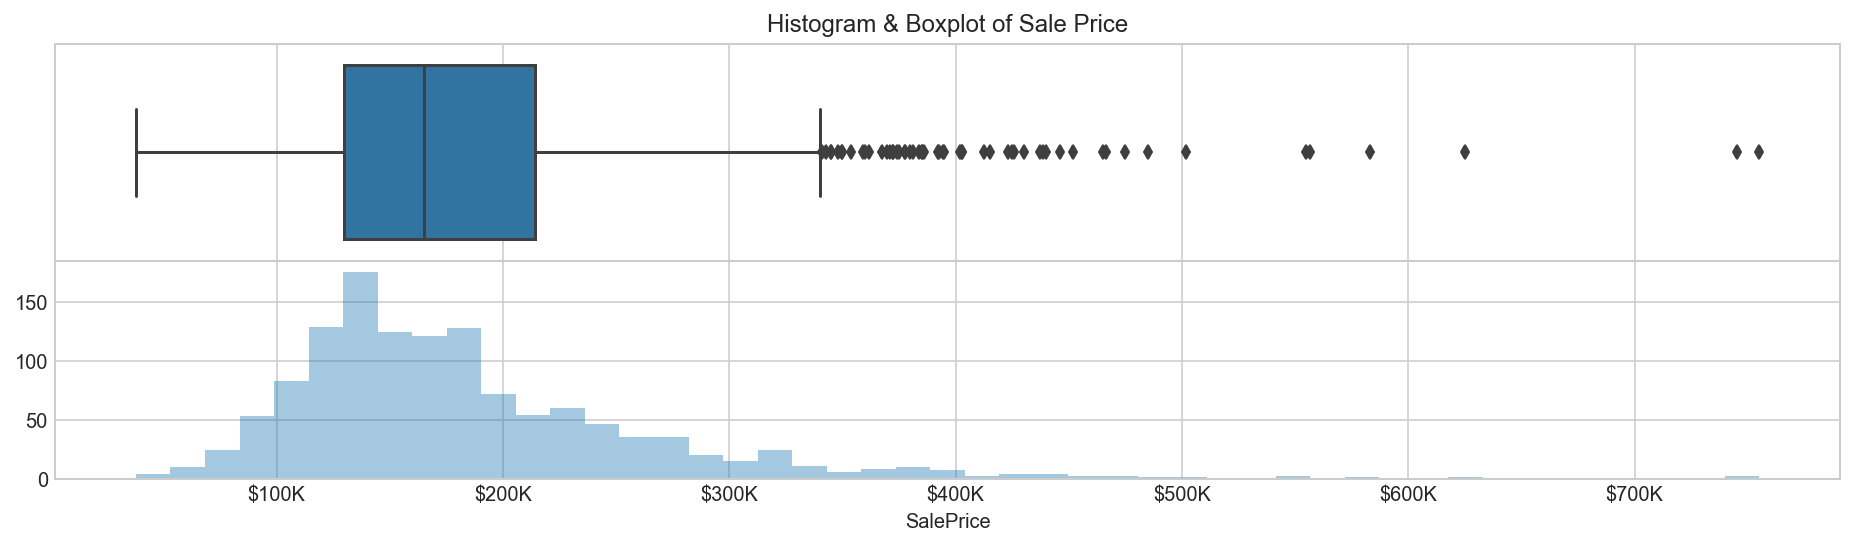

In [29]:
fig, ax = plt.subplots(2, sharex = True, figsize = (16,4))
ax[0] = sns.boxplot(house_train["SalePrice"], ax = ax[0])
ax[1] = sns.distplot(house_train["SalePrice"],kde = False, ax = ax[1])

formatter = FuncFormatter(currency)
ax[1].xaxis.set_major_formatter(formatter)

ax[0].set_title("Histogram & Boxplot of Sale Price")
fig.subplots_adjust(hspace=0)

plt.show()

In [31]:
house["LogSalePrice"] = np.log(house["SalePrice"])
house.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Age,Remod_Age,Total_SF,LogSalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500,7,7,2566,12.247694
2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500,34,34,2524,12.109011
3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500,9,8,2706,12.317167
4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000,95,40,2473,11.849398
5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000,10,10,3343,12.429216


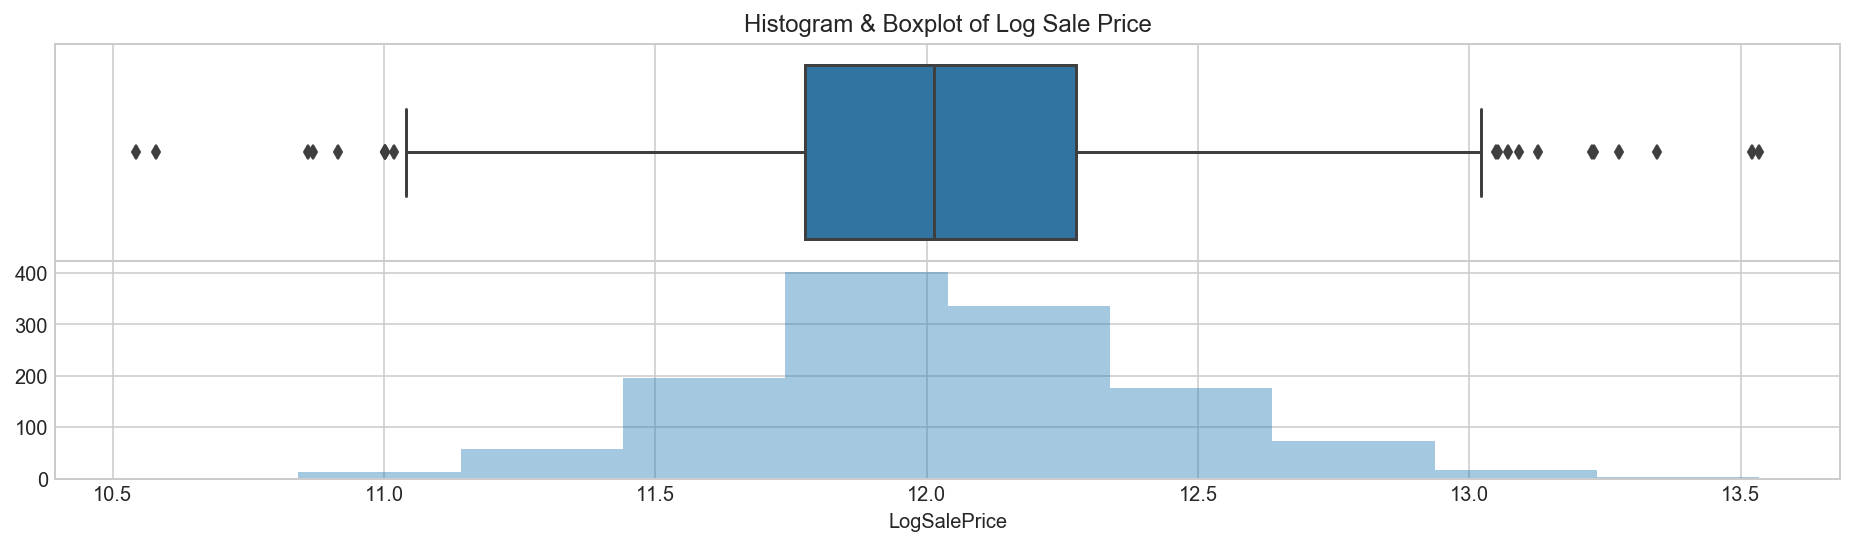

In [34]:
house_train = house[train]

fig, ax = plt.subplots(2, sharex = True, figsize = (16,4))
ax[0] = sns.boxplot(house_train["LogSalePrice"], ax = ax[0])
ax[1] = sns.distplot(house_train["LogSalePrice"],kde = False, ax = ax[1], bins = 10)

ax[0].set_title("Histogram & Boxplot of Log Sale Price")
fig.subplots_adjust(hspace=0)

plt.show()

In [40]:
#select fixed categories
fixed_cats = ["Alley", 
              "MSSubClass", 
              "BldgType", 
              "LotShape", 
              "LandContour", 
              "LotConfig", 
              "LandSlope", 
              "Condition1"]
#feature selection


# fixed_cat = ["MSSubClass",
# "MSZoning",
# "LotArea",
# "LotShape",
# "LotFrontage",               
# "LotConfig",
# "Neighborhood",
# "Condition1",
# "BldgType",
# "HouseStyle",
# "YearBuilt",
# "Foundation",
# "1stFlrSF",
# "2ndFlrSF",
# "GrLivArea",
# "BsmtFullBath",
# "BsmtHalfBath",
# "FullBath",
# "HalfBath",
# "BedroomAbvGr",
# "TotRmsAbvGrd",
# "GarageCars",
# "GarageArea","YrSold"]

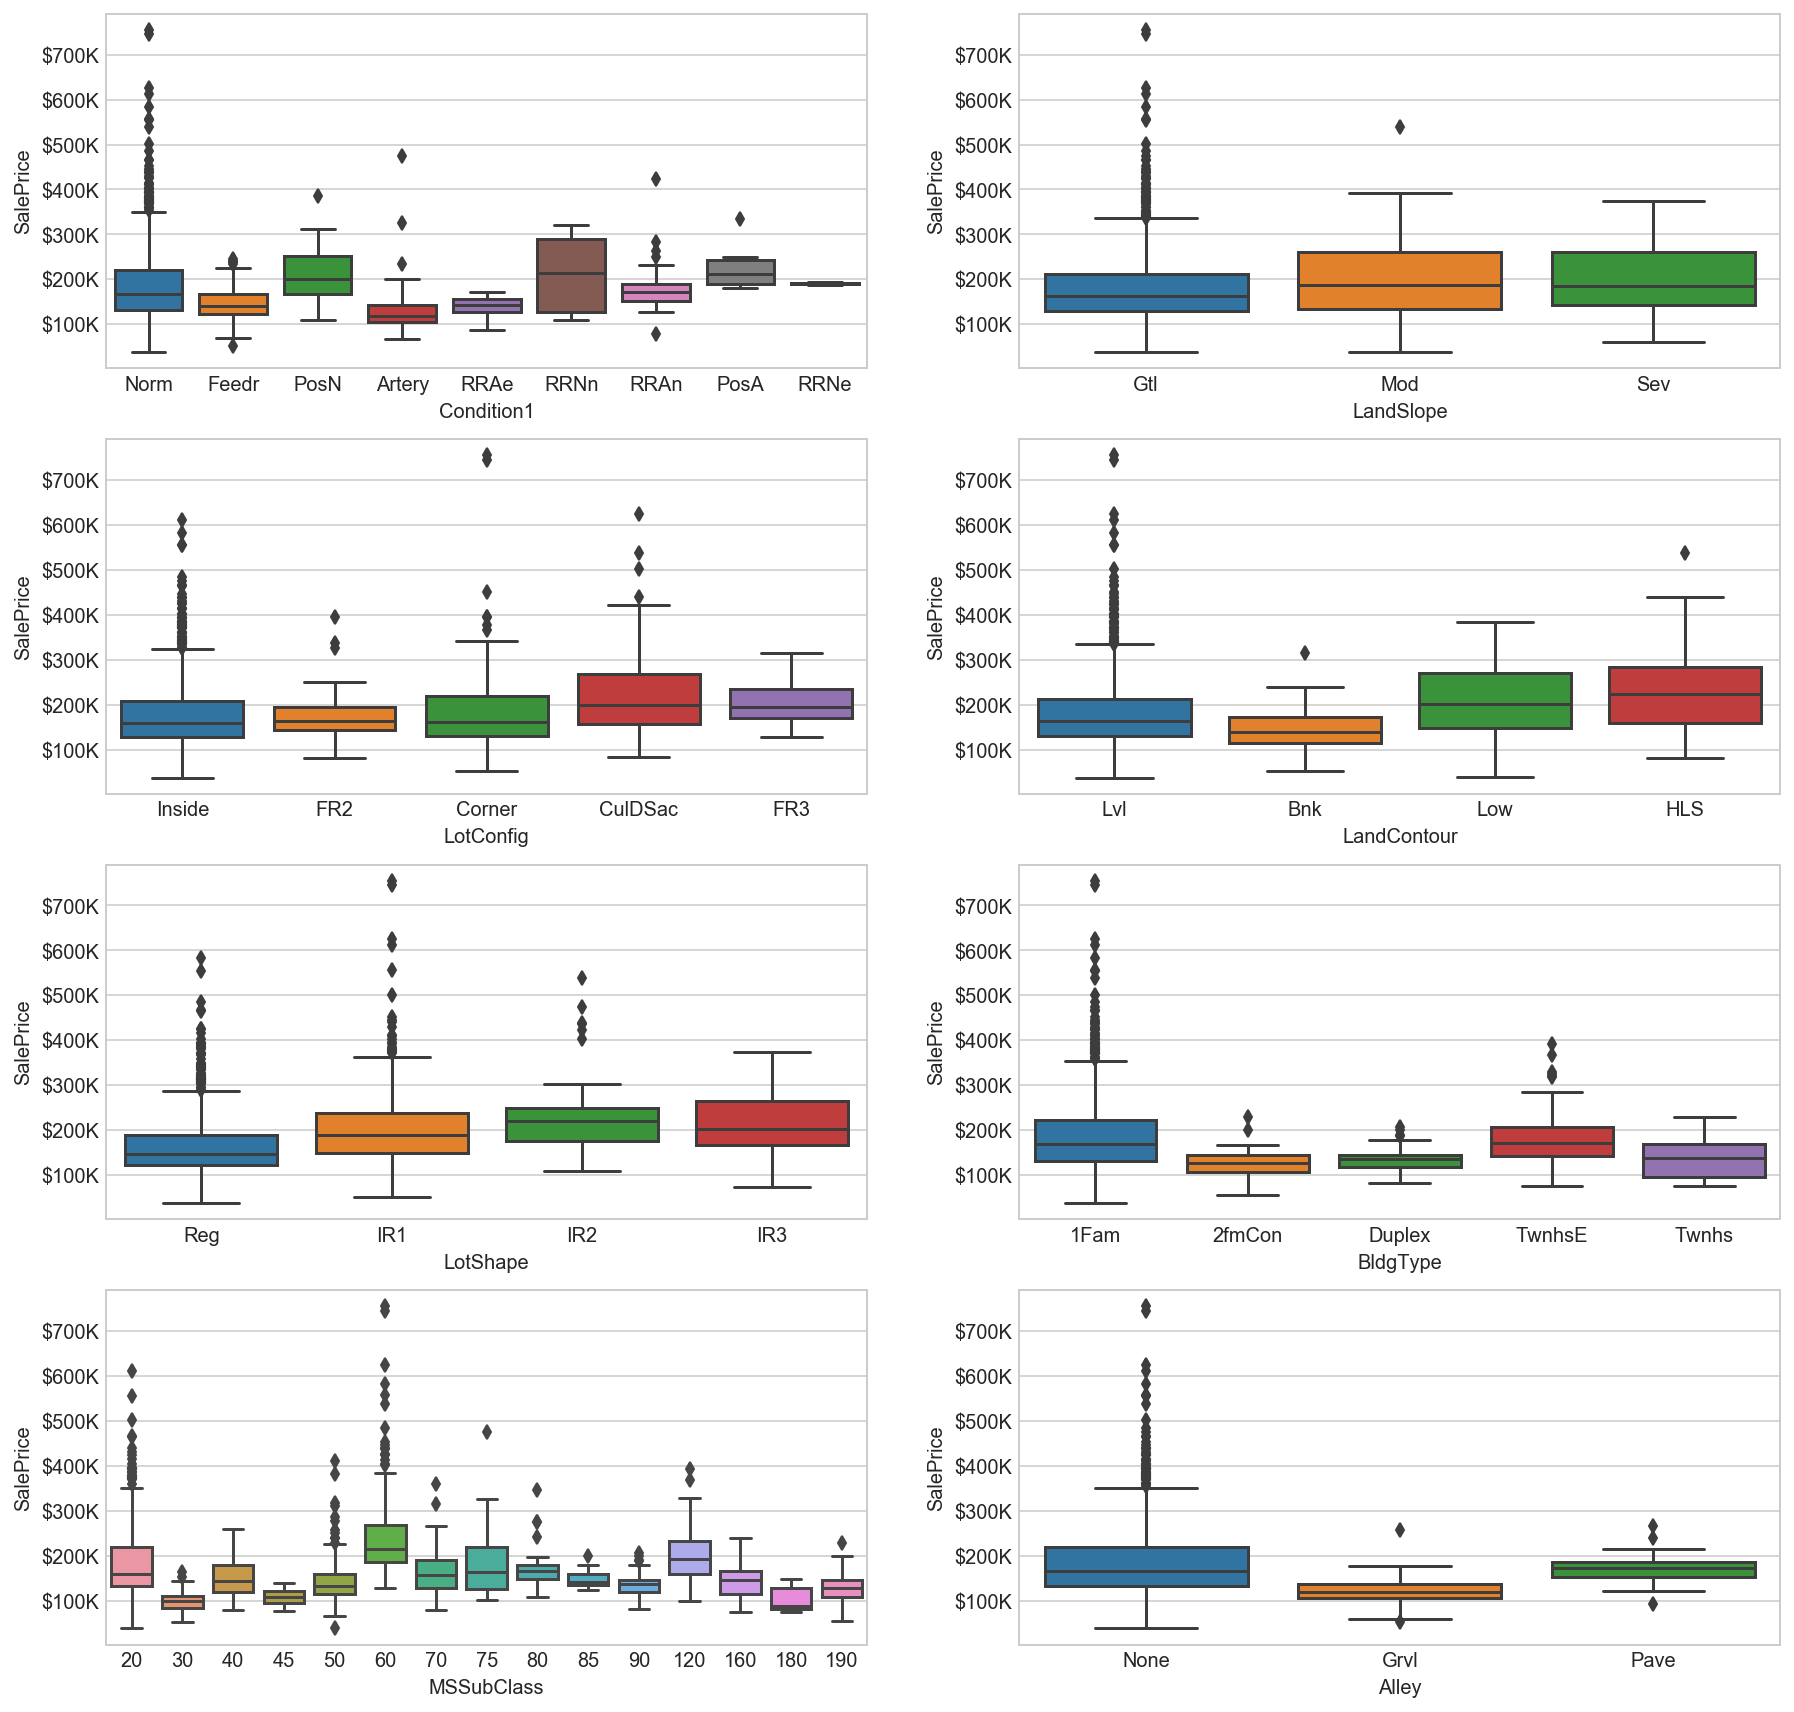

In [41]:
#plot all bloxplot for the fixed categories
fig, ax = plt.subplots(int(len(fixed_cats)/2),2, figsize = (15,15))

ax = ax.flatten()
for i in range(len(fixed_cats)):
    ax[i] = sns.boxplot(x = house[fixed_cats.pop()], y =house["SalePrice"], ax = ax[i])
    formatter = FuncFormatter(currency)
    ax[i].yaxis.set_major_formatter(formatter)

In [43]:
# fig, ax = plt.subplots(int(len(fixed_cats)/2),2, figsize = (15,15))

# ax = ax.flatten()
# for i in range(len(fixed_cats)):
#     ax[i] = sns.countplot(house[fixed_cats.pop()], ax = ax[i])

In [44]:
#sort by sale price
neighborhood_prices = house.loc[:, ["SalePrice", "Neighborhood"]].groupby(by = "Neighborhood").median().sort_values(by = "SalePrice", ascending = False)

#create column to store median price of the neighborhood for each house
house["NeighborhoodPrice"] = [neighborhood_prices.loc[x,"SalePrice"] for x in house["Neighborhood"]]

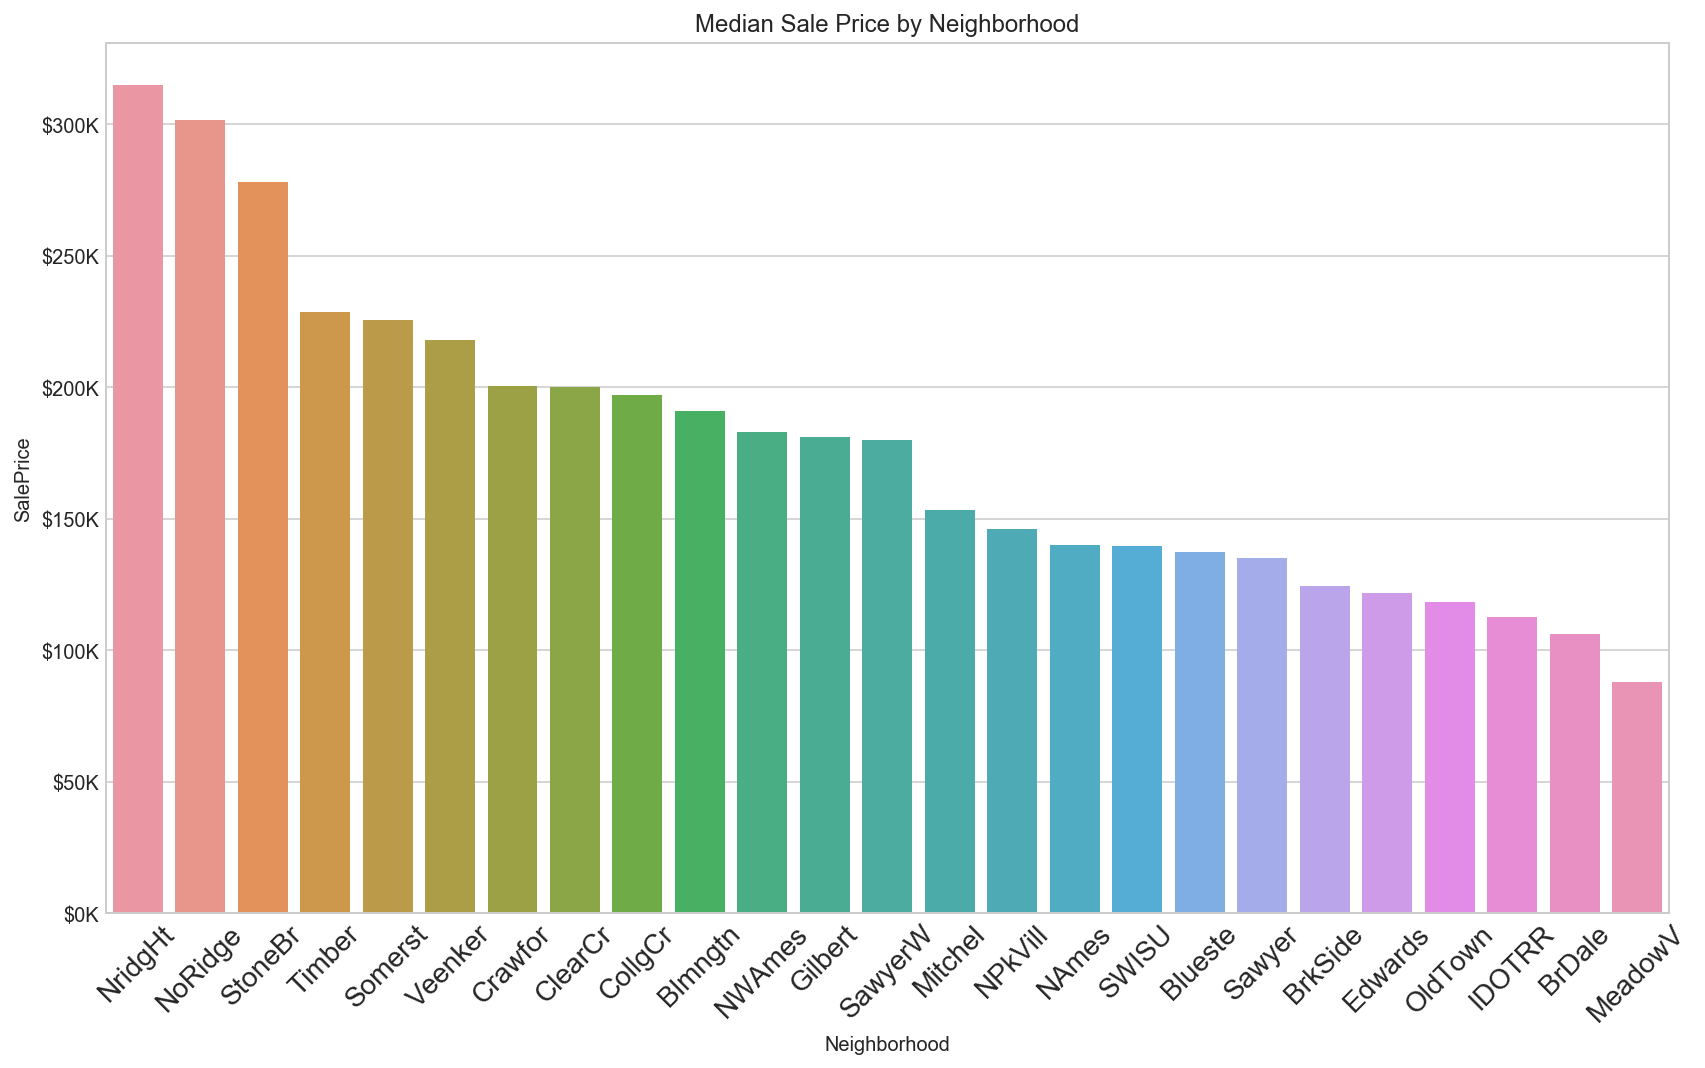

In [45]:
fig, ax = plt.subplots(figsize = (14,8))

formatter = FuncFormatter(currency)
ax.yaxis.set_major_formatter(formatter)

ax.set_title("Median Sale Price by Neighborhood")
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=45)


ax = sns.barplot(x = neighborhood_prices.index, y = "SalePrice", data = neighborhood_prices)

In [46]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

#splitting after standardizing w/ patsy
fix_feat = '~ BsmtFinSF1 + GrLivArea + FullBath + TotRmsAbvGrd + Fireplaces + GarageArea + WoodDeckSF +\
            Total_SF + NeighborhoodPrice + C(Condition1) + C(BldgType) + C(LotShape) + Age -1'

X = patsy.dmatrix(fix_feat, data=house, return_type='dataframe')
y = house["LogSalePrice"]

ss = StandardScaler()
Xs = ss.fit_transform(X)

Xs_train = Xs[train]
Xs_test = Xs[test]

y_train = y[train]
y_test = y[test]

slr = LinearRegression()

model = slr.fit(Xs_train, y_train)

print("The R-squared score of the training dataset is: {:.2f}%".format(model.score(Xs_train,y_train)*100))
print("The R-squared score of the testing dataset is: {:.2f}%".format(model.score(Xs_test,y_test)*100))

yfixed_testpreds = model.predict(Xs_test)
yfixed_trainpreds = model.predict(Xs_train)

print("--------------------------------------------------------")
print("The RMSE of the training set is {:.2f}".format(np.sqrt(mean_squared_error(y_train, yfixed_trainpreds))))
print("The RMSE of the testing set is {:.2f}".format(np.sqrt(mean_squared_error(y_test, yfixed_testpreds))))

The R-squared score of the training dataset is: 82.86%
The R-squared score of the testing dataset is: 86.78%
--------------------------------------------------------
The RMSE of the training set is 0.16
The RMSE of the testing set is 0.14


In [47]:
import statsmodels.formula.api as smf

fix_feat_smf = "LogSalePrice" + fix_feat

results = smf.ols(fix_feat_smf, data=house).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           LogSalePrice   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     285.7
Date:                Fri, 06 Apr 2018   Prob (F-statistic):               0.00
Time:                        01:31:07   Log-Likelihood:                 602.56
No. Observations:                1450   AIC:                            -1153.
Df Residuals:                    1424   BIC:                            -1016.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
C(Condition1)[Artery]    11.0166      0.041    269.206      0.000      10.936      11.097
C(Condition1)[Feedr]     10.9865      0.037    296.663      0.000      10.914      11.059
C(Condition1)[Norm]      11.0676      0.032    344.017      0.000      11.004      11.131
C(Condition1)[PosA]      11.1071      0.066    168.544      0.000      10.978      11.236
C(Condition1)[PosN]      11.0191      0.050    221.146      0.000      10.921      11.117
C(Condition1)[RRAe]      10.9562      0.057    191.900      0.000      10.844      11.068
C(Condition1)[RRAn]      11.0927      0.045    247.300      0.000      11.005      11.181
C(Condition1)[RRNe]      11.0787      0.118     93.917      0.000      10.847      11.310
C(Condition1)[RRNn]      11.1472      0.079    141.101      0.000      10.992      11.302
C(BldgType)[T.2fmCon]    -0.0784      0.031     -2.542      0.011      -0.139      -0.018
C(BldgType)[T.Duplex]    -0.1581      0.024     -6.497      0.000      -0.206      -0.110
C(BldgType)[T.Twnhs]     -0.1401      0.026     -5.348      0.000      -0.191      -0.089
C(BldgType)[T.TwnhsE]    -0.0492      0.017     -2.847      0.004      -0.083      -0.015
C(LotShape)[T.IR2]        0.0640      0.026      2.423      0.016       0.012       0.116
C(LotShape)[T.IR3]       -0.1932      0.053     -3.659      0.000      -0.297      -0.090
C(LotShape)[T.Reg]       -0.0071      0.010     -0.729      0.466      -0.026       0.012
BsmtFinSF1             6.158e-05   1.15e-05      5.360      0.000     3.9e-05    8.41e-05
GrLivArea                 0.0001   2.41e-05      5.610      0.000    8.81e-05       0.000
FullBath                  0.0254      0.012      2.178      0.030       0.003       0.048
TotRmsAbvGrd              0.0143      0.005      2.806      0.005       0.004       0.024
Fireplaces                0.0639      0.008      8.209      0.000       0.049       0.079
GarageArea                0.0003   2.69e-05      9.335      0.000       0.000       0.000
WoodDeckSF                0.0001   3.62e-05      3.270      0.001    4.74e-05       0.000
Total_SF               8.782e-05   1.33e-05      6.597      0.000    6.17e-05       0.000
NeighborhoodPrice      1.814e-06   1.16e-07     15.662      0.000    1.59e-06    2.04e-06
Age                      -0.0024      0.000    -10.536      0.000      -0.003      -0.002
==============================================================================
Omnibus:                      789.513   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            23610.492
Skew:                          -1.960   Prob(JB):                         0.00
Kurtosis:                      22.376   Cond. No.                     5.36e+06
==============================================================================

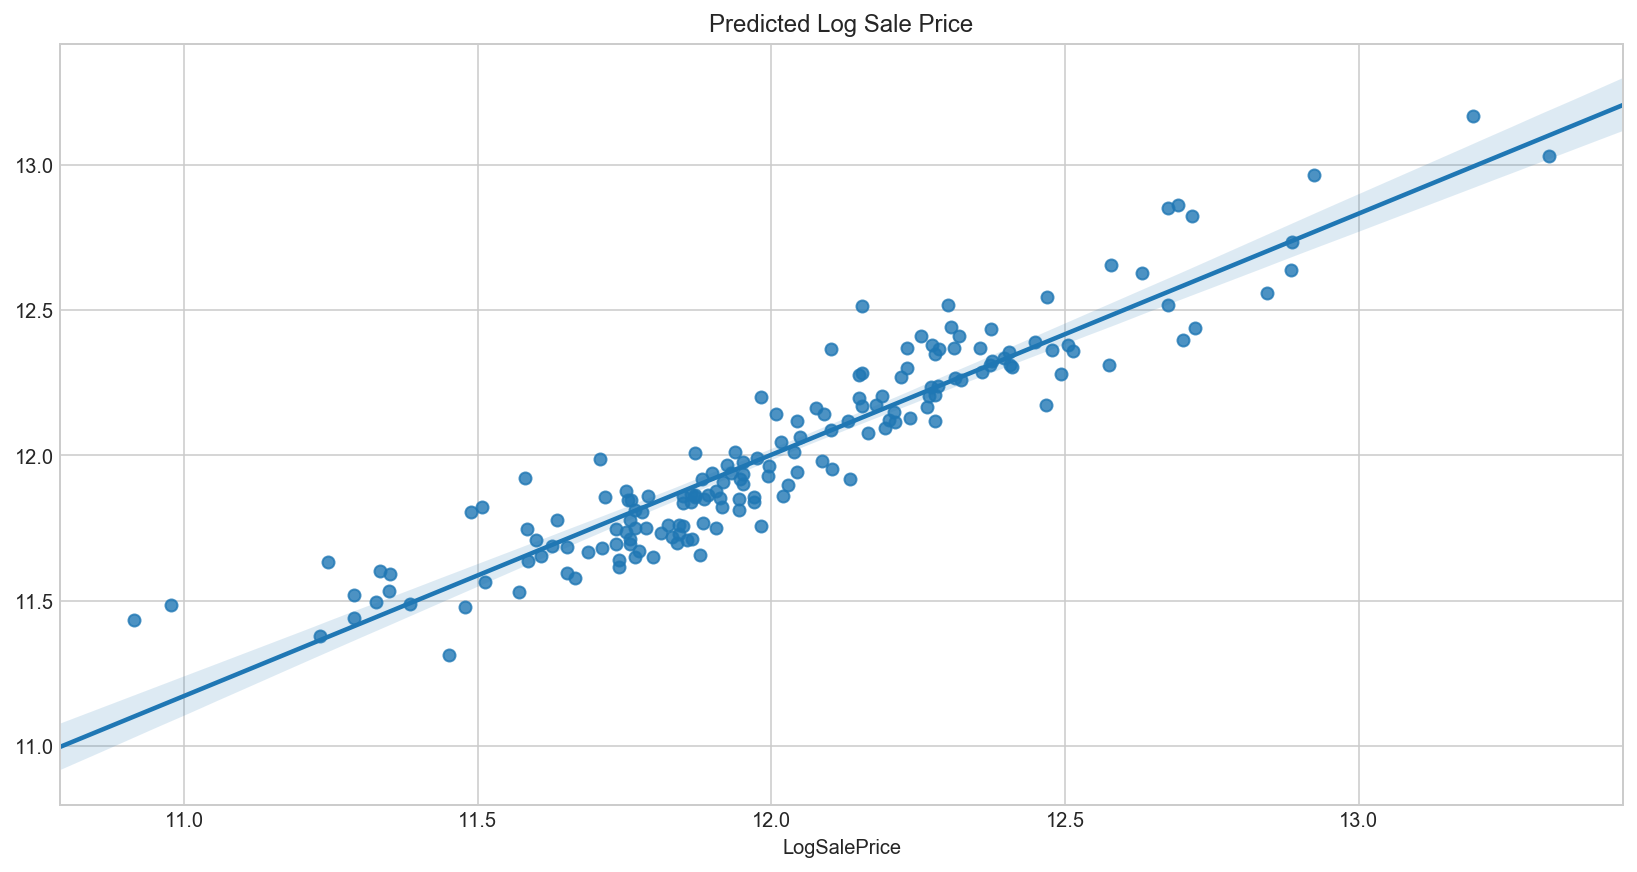

The RMSE of the testing set is 0.14


In [52]:
fig, ax = plt.subplots(figsize = (14,7))

ax.set_title("Cross Validation Predications against actual Log Sale Price Values")
ax.set_xlabel("Actual Log Sale Price")
ax.set_title("Predicted Log Sale Price")

ax = sns.regplot(y_test, yfixed_testpreds)

plt.show()

print("The RMSE of the testing set is {:.2f}".format(np.sqrt(mean_squared_error(y_test, yfixed_testpreds))))

In [ ]:
# Under a basic Cross Validated Simple Linear Regression Model with 10 folds, the model is able to explain 86.17% of the variances (R-Squared).

# Predictions did fairly well against the actual log prices with an RMSE of only 0.14 for the testing model, not too far off the 0.16 for training.

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [55]:
#define columns to select
renovatables = ["OverallQual", 
                "OverallCond", 
                "ExterQual", 
                "ExterCond", 
                "BsmtQual", 
                "BsmtCond", 
                "BsmtFinType1", 
                "BsmtFinType2", 
                "HeatingQC",
                "CentralAir",
                "KitchenQual", 
                "Electrical", 
                "GarageQual",
                "GarageCond"]

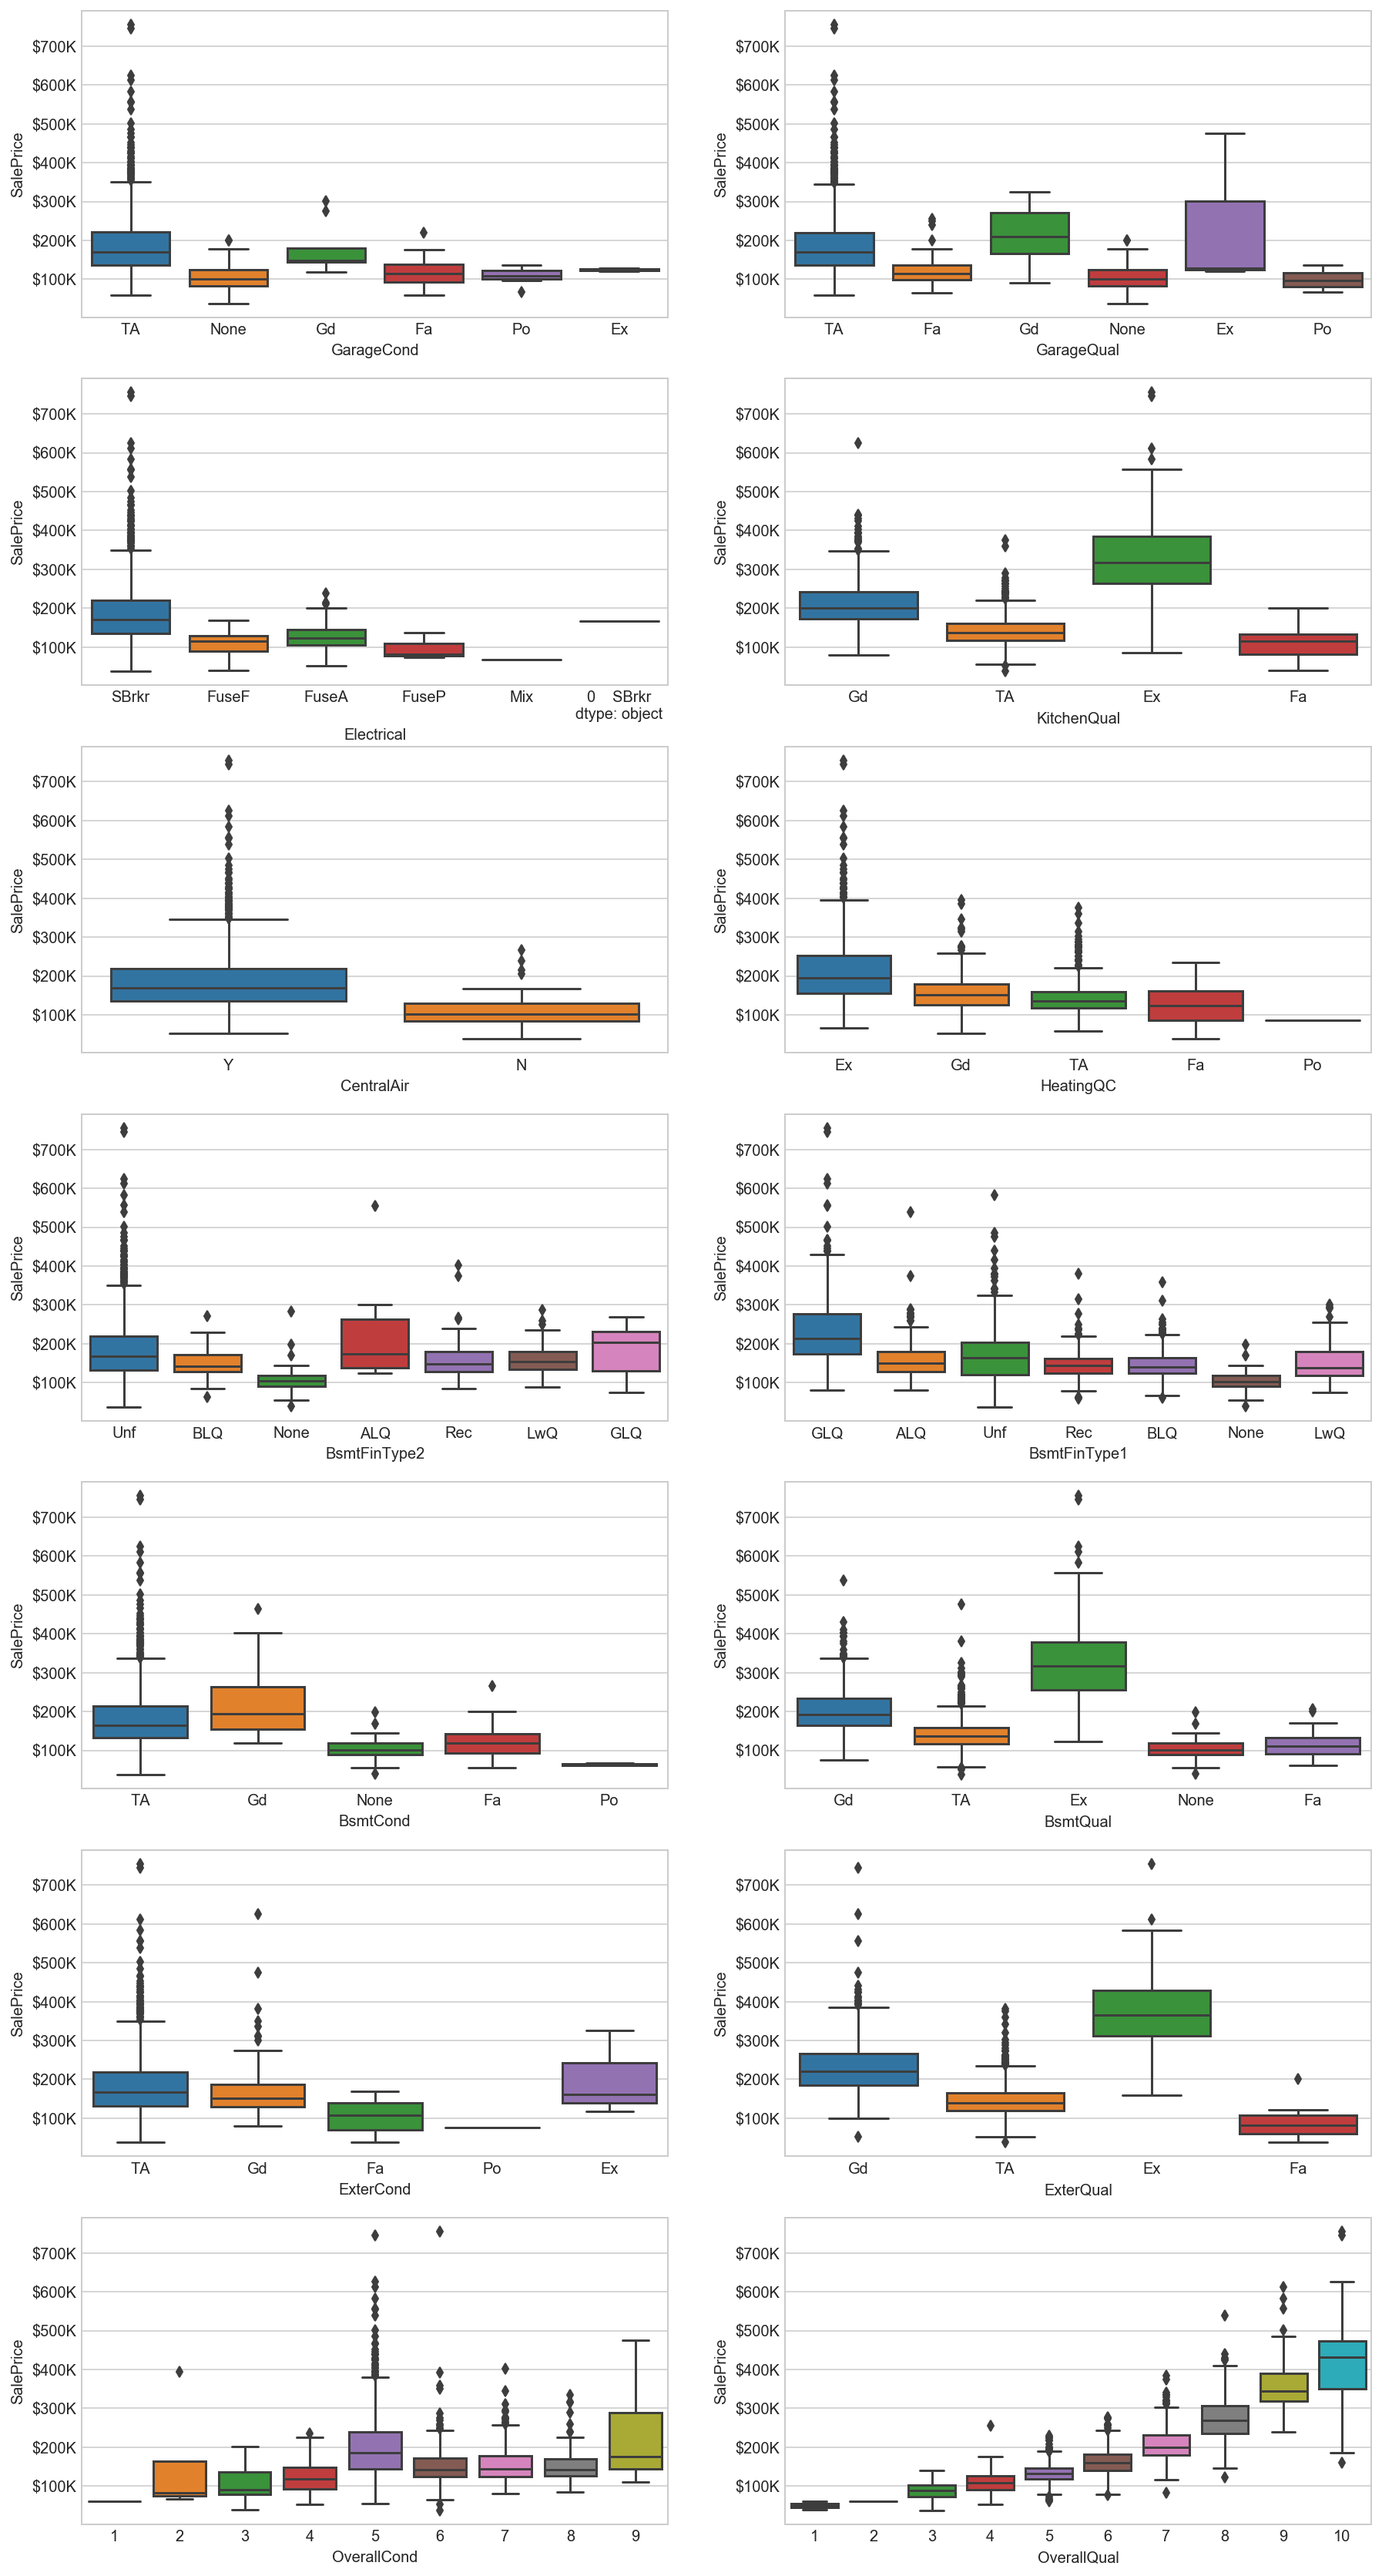

In [56]:
fig, ax = plt.subplots(int(len(renovatables)/2),2, figsize = (15,30))

ax = ax.flatten()
for i in range(len(renovatables)):
    ax[i] = sns.boxplot(x = house[renovatables.pop()], y = house["SalePrice"], ax = ax[i])
    formatter = FuncFormatter(currency)
    ax[i].yaxis.set_major_formatter(formatter)

plt.show()

In [57]:
changeable_feat =  "+ C(OverallQual) + C(OverallCond) + C(KitchenQual) + C(CentralAir) + C(HeatingQC) + C(Functional)"

#assign fixed features and changeables features to use in patsy:all_feat
all_feat = fix_feat + changeable_feat

In [58]:
X_r = patsy.dmatrix(all_feat, data=house, return_type='dataframe')
y_r = house["LogSalePrice"]

#Standardize X matrix:
ss = StandardScaler()
X_rn = ss.fit_transform(X_r)

Xrn_train = X_rn[train]
Xrn_test = X_rn[test]

yr_train = y_r[train]
yr_test = y_r[test]

slr = LinearRegression()

model = slr.fit(Xrn_train, yr_train)


print("The R-squared score of the training dataset is: {:.2f}%".format(model.score(Xrn_train,yr_train)*100))
print("The R-squared score of the testing dataset is: {:.2f}%".format(model.score(Xrn_test,yr_test)*100))

ychange_trainpreds = model.predict(Xrn_train)
ychange_testpreds = model.predict(Xrn_test)

print("--------------------------------------------------------")
print("The RMSE of the training set is {:.2f}".format(np.sqrt(mean_squared_error(yr_train, ychange_trainpreds))))
print("The RMSE of the testing set is {:.2f}".format(np.sqrt(mean_squared_error(yr_test, ychange_testpreds))))

The R-squared score of the training dataset is: 88.61%
The R-squared score of the testing dataset is: 90.04%
--------------------------------------------------------
The RMSE of the training set is 0.13
The RMSE of the testing set is 0.12


In [59]:
changeable_feat = "SalePrice" + all_feat

results = smf.ols(changeable_feat, data=house).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     152.7
Date:                Fri, 06 Apr 2018   Prob (F-statistic):               0.00
Time:                        08:31:36   Log-Likelihood:                -16987.
No. Observations:                1450   AIC:                         3.409e+04
Df Residuals:                    1393   BIC:                         3.439e+04
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
C(Condition1)[Artery]  1.182e+04   3.22e+04      0.367      0.713   -5.13e+04     7.5e+04
C(Condition1)[Feedr]   8193.0270   3.21e+04      0.256      0.798   -5.47e+04    7.11e+04
C(Condition1)[Norm]    2.378e+04   3.18e+04      0.749      0.454   -3.85e+04    8.61e+04
C(Condition1)[PosA]    2.541e+04   3.35e+04      0.758      0.449   -4.04e+04    9.12e+04
C(Condition1)[PosN]    2316.8814   3.26e+04      0.071      0.943   -6.16e+04    6.62e+04
C(Condition1)[RRAe]    7960.0007   3.32e+04      0.240      0.810   -5.71e+04     7.3e+04
C(Condition1)[RRAn]    2.599e+04   3.24e+04      0.803      0.422   -3.75e+04    8.95e+04
C(Condition1)[RRNe]    1.078e+04   3.82e+04      0.282      0.778   -6.42e+04    8.58e+04
C(Condition1)[RRNn]    2.171e+04   3.45e+04      0.630      0.529   -4.59e+04    8.94e+04
C(BldgType)[T.2fmCon] -8523.0475   6024.734     -1.415      0.157   -2.03e+04    3295.484
C(BldgType)[T.Duplex] -1.367e+04   4865.435     -2.809      0.005   -2.32e+04   -4125.000
C(BldgType)[T.Twnhs]   -2.31e+04   5005.808     -4.614      0.000   -3.29e+04   -1.33e+04
C(BldgType)[T.TwnhsE] -1.533e+04   3305.745     -4.637      0.000   -2.18e+04   -8844.156
C(LotShape)[T.IR2]     1.669e+04   4980.143      3.352      0.001    6925.010    2.65e+04
C(LotShape)[T.IR3]    -2.576e+04   9997.840     -2.576      0.010   -4.54e+04   -6146.385
C(LotShape)[T.Reg]    -1047.3652   1842.493     -0.568      0.570   -4661.726    2566.996
C(OverallQual)[T.2L]  -3326.8894   3.76e+04     -0.088      0.930   -7.71e+04    7.04e+04
C(OverallQual)[T.3L]  -1.274e+04   3.23e+04     -0.395      0.693   -7.61e+04    5.06e+04
C(OverallQual)[T.4L]  -8041.2251   3.18e+04     -0.253      0.800   -7.05e+04    5.44e+04
C(OverallQual)[T.5L]  -8996.9389   3.19e+04     -0.282      0.778   -7.16e+04    5.36e+04
C(OverallQual)[T.6L]  -4449.0920   3.19e+04     -0.139      0.889    -6.7e+04    5.81e+04
C(OverallQual)[T.7L]   5703.5079    3.2e+04      0.178      0.859   -5.71e+04    6.85e+04
C(OverallQual)[T.8L]   3.179e+04   3.22e+04      0.988      0.324   -3.14e+04    9.49e+04
C(OverallQual)[T.9L]   8.302e+04   3.27e+04      2.538      0.011    1.88e+04    1.47e+05
C(OverallQual)[T.10L]   1.01e+05   3.34e+04      3.023      0.003    3.55e+04    1.67e+05
C(OverallCond)[T.2L]  -1232.5935   4.74e+04     -0.026      0.979   -9.42e+04    9.18e+04
C(OverallCond)[T.3L]  -6332.8099   4.42e+04     -0.143      0.886    -9.3e+04    8.03e+04
C(OverallCond)[T.4L]   5356.1773   4.49e+04      0.119      0.905   -8.27e+04    9.34e+04
C(OverallCond)[T.5L]   1.012e+04   4.48e+04      0.226      0.821   -7.78e+04    9.81e+04
C(OverallCond)[T.6L]    1.61e+04   4.48e+04      0.359      0.719   -7.18e+04    1.04e+05
C(OverallCond)[T.7L]   2.547e+04   4.48e+04      0.568      0.570   -6.25e+04    1.13e+05
C(OverallCond)[T.8L]   

In [ ]:
#made some improvements compared to our model used for fixed characteristics. Our 
#R-squared score from our testing dataset is 90.04% up from our original 86.78%.

#Real Mean Squared Error is also now reduced to 0.13 down from 0.16 and 0.14.

#as a reminder, we looked at these renovatable charateristics to further explore.

#OverallQual
#from our regression with the SalesPrice, it appears to be beneficial to renovate if the Overall Quality of the house is rated below a 6, as each increment of tier from 6 to 9 increases by roughly $20k - $50k

#OverallCond
#Overall Condition does not seem to have as much affect compared to OverallQual

# KitchenQual
# CentralAir
# HeatingQC
# Functional

In [61]:
#trying other models
from sklearn import linear_model

lasso = linear_model.Lasso(alpha=0.01)
model = lasso.fit(Xrn_train, yr_train)

print("The R-squared score of the training dataset is: {:.2f}%".format(model.score(Xrn_train,yr_train)*100))
print("The R-squared score of the testing dataset is: {:.2f}%".format(model.score(Xrn_test,yr_test)*100))

ylasso_trainpreds = lasso.predict(Xrn_train)
ylasso_testpreds = lasso.predict(Xrn_test)

print("--------------------------------------------------------")
print("The RMSE of the training set is {:.2f}".format(np.sqrt(mean_squared_error(yr_train, ylasso_trainpreds))))
print("The RMSE of the testing set is {:.2f}".format(np.sqrt(mean_squared_error(yr_test, ylasso_testpreds))))

The R-squared score of the training dataset is: 86.62%
The R-squared score of the testing dataset is: 89.09%
--------------------------------------------------------
The RMSE of the training set is 0.14
The RMSE of the testing set is 0.13


<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [20]:
# A: